In [ ]:
from data import digs_data_loader
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser_vpsde
from analysis import plotting
from analysis import utils as au
from model import loss
from model import reverse_se3_diffusion
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from collections import defaultdict
from mpl_toolkits import mplot3d
import numpy as np
from scipy.spatial.transform import Rotation

Rigid = ru.Rigid

from omegaconf import OmegaConf
import importlib
import os
import torch
import tree
import copy

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
importlib.reload(digs_data_loader)
importlib.reload(reverse_se3_diffusion)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(au)
importlib.reload(train_se3_diffusion)
importlib.reload(r3_diffuser_vpsde)

In [ ]:
base_conf_path = '../config/base.yaml'
base_conf = OmegaConf.load(base_conf_path)

# Load model checkpoint
# ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_20D_08M_2022Y_06h_23m_25s/'
# ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_rescale_20D_08M_2022Y_08h_40m_20s'
# ckpt_dir = '../pkl_jar/ckpt/sanity_check_no_crop_20D_08M_2022Y_11h_04m_15s'
# ckpt_dir = '../pkl_jar/ckpt/mini_subset_len_50_20D_08M_2022Y_12h_11m_52s'
# ckpt_dir = '../pkl_jar/ckpt/mini_subset_20D_08M_2022Y_12h_40m_22s'

ckpt_dir = '../pkl_jar/ckpt/mini_subset_20D_08M_2022Y_13h_04m_15s'
# ckpt_dir = '../pkl_jar/ckpt/subset_100_20D_08M_2022Y_18h_43m_20s'


if len(os.listdir(ckpt_dir)) != 1:
    raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
ckpt_path = os.path.join(
    ckpt_dir, os.listdir(ckpt_dir)[0])
ckpt_pkl = du.read_pkl(ckpt_path)
ckpt_conf = ckpt_pkl['conf']
ckpt_model = ckpt_pkl['model']

conf = OmegaConf.merge(base_conf, ckpt_conf)
conf.data.digs.cache_dir = '../pkl_jar/'

model_conf = conf.model
# model_conf.num_blocks = 1

print(ckpt_path)
# print(OmegaConf.to_yaml(ckpt_conf))

In [ ]:
# # Load config.
# conf = OmegaConf.load('../config/base.yaml')
# # rocklin_conf = OmegaConf.load('../config/sanity_check_rocklin.yaml')
# # debug_conf = OmegaConf.load('../config/debug.yaml')
# # conf = OmegaConf.merge(conf, rocklin_conf)
# conf = OmegaConf.merge(conf, ckpt_conf)

# # Redirect cache from notebook directory.
# exp_conf = conf.experiment
# exp_conf.ckpt_dir = None
# exp_conf.num_loader_workers = 1
# exp_conf.num_epoch = 10000
# exp_conf.dist_mode = 'single'
# exp_conf.use_wandb = False

# data_conf = conf.data
# data_conf.rosetta.max_examples = 1
# data_conf.rosetta.max_len = 100
# data_conf.rosetta.use_rocklin = True

# diff_conf = conf.diffuser
# diff_conf.diffuse_trans = True

# model_conf = conf.model
# model_conf.num_blocks = 1

# # print(OmegaConf.to_yaml(conf))

In [ ]:
# Initialize model class
exp = train_se3_diffusion.Experiment(conf=conf)
# exp.model.load_state_dict(ckpt_model)
exp.model.to(device)
exp_diffuser = exp.diffuser
train_loader, _, valid_loader, _ = exp.create_digs_dataset(0, 1)
exp_diffuser = exp.diffuser

In [ ]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

## Training

In [ ]:
num_epochs = 1
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

In [ ]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Total loss')

## Equivariance test

In [ ]:
# Toy test case
# x_0 = torch.tile(torch.eye(3)[None], (3, 1))
# x_0 = torch.Tensor([[
#     [-1.0, 0.0, 0.0],
#     [0.0, 0.0, 0.0],
#     [0.0, 1.0, 0.0],
# ]])
x_0 = torch.Tensor([[
    [-1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
]])

rigids_0 = du.rigid_frames_from_atom_14(x_0)
frames_0 = rigids_0.to_tensor_7()
mat_0 = rigids_0.get_rots().get_rot_mats()

rot = torch.tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix()).float()
x_rot = torch.einsum('...i,ji->...j', x_0, rot)
rigids_rot = du.rigid_frames_from_atom_14(x_rot)
frames_rot = rigids_rot.to_tensor_7()
mat_rot = rigids_rot.get_rots().get_rot_mats()

rot_to_euler = lambda x: Rotation.from_matrix(x).as_euler('xyz', degrees=True)
print(rot_to_euler(mat_rot[0]))
print(rot_to_euler(torch.einsum('ij,jk->ik', mat_0[0], rot)))

In [ ]:
# Create copy of rotated features
b_idx = 0
data_raw = tree.map_structure(lambda x: x.to('cpu')[b_idx:b_idx+1], raw_data_feats)
res_mask = data_raw['res_mask'].bool()
data_raw['rigids_0'] = data_raw['rigids_0'][torch.where(res_mask)][None]
data_raw['rigids_t'] = data_raw['rigids_0']
data_raw['res_mask'] = data_raw['res_mask'][torch.where(res_mask)][None]
data_raw['res_idx'] = data_raw['res_idx'][torch.where(res_mask)][None]
data_raw['xyz'] = data_raw['xyz'][torch.where(res_mask)][None] / 10.0
data_raw = tree.map_structure(lambda x: x.to(device), data_raw)

In [ ]:
# x_0 = data_raw['xyz'][:, 2]
# rigids_0 = du.rigid_frames_from_atom_14(x_0)
# frames_0 = rigids_0.to_tensor_7()
# mat_0 = rigids_0.get_rots().get_rot_mats()
# # print(frames_0[0])
# # print(data_raw['rigids_0'][0, 2])

# rot = torch.tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix()).float()
# x_rot = torch.einsum('...i,ji->...j', x_0, rot.to(x_0.device))
# rigids_rot = du.rigid_frames_from_atom_14(x_rot)
# frames_rot = rigids_rot.to_tensor_7()
# mat_rot = rigids_rot.get_rots().get_rot_mats()

# rot_to_euler = lambda x: Rotation.from_matrix(x).as_euler('xyz', degrees=True)
# print(rot_to_euler(du.move_to_np(mat_rot[0])))
# print(rot_to_euler(du.move_to_np(torch.einsum('ij,jk->ik', mat_0[0], rot.to(mat_0.device)))))

In [ ]:
data_perturbed = copy.deepcopy(data_raw)
atom_pos = du.move_to_np(data_raw['xyz'])
res_mask = du.move_to_np(data_raw['res_mask'])
# rand_rot = Rotation.random().as_matrix()
rand_rot = torch.tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix()).float()

# perturbed_atom_pos = np.einsum('ij,...i->...j', rand_rot, atom_pos) + 10.0
# perturbed_atom_pos = atom_pos + 10.0
# perturbed_atom_pos = np.einsum('ij,...i->...j', rand_rot, atom_pos)
perturbed_atom_pos = np.einsum('...i,ji->...j', atom_pos, rand_rot) + 10.0
# perturbed_atom_pos = atom_pos @ rand_rot

# perturbed_atom_pos *= res_mask[..., None, None]
perturbed_frames = du.rigid_frames_from_atom_14(
    torch.Tensor(perturbed_atom_pos[0]).to(device))
data_perturbed['rigids_0'] = perturbed_frames.to_tensor_7()[None]
data_perturbed['rigids_t'] = perturbed_frames.to_tensor_7()[None]

In [ ]:
# raw_frame = Rigid.from_tensor_7(data_raw['rigids_0'][0, 2])
# perturbed_frame = Rigid.from_tensor_7(data_perturbed['rigids_0'][0, 2])

# raw_rot = du.move_to_np(raw_frame.get_rots().get_rot_mats())
# perturbed_rot = du.move_to_np(perturbed_frame.get_rots().get_rot_mats())
# print(perturbed_rot)
# print(np.einsum('ij,jk->ik', raw_rot, rand_rot))

In [ ]:
model_out = exp.model(data_raw)
model_out_perturbed = exp.model(data_perturbed)

trans_out = du.move_to_np(model_out['trans_score'][0])
trans_out_perturbed = du.move_to_np(model_out_perturbed['trans_score'][0])

rot_out = du.move_to_np(model_out['rot_score'][0])
rot_out_perturbed = du.move_to_np(model_out_perturbed['rot_score'][0])

local_trans_out = du.move_to_np(model_out['local_trans_score'][0])
local_trans_out_perturbed = du.move_to_np(model_out_perturbed['local_trans_score'][0])

# print(local_trans_out[:3])
# print(local_trans_out_perturbed[:3])

# print(rot_out[:3])
# print(rot_out_perturbed[:3])

# Translation score should be equivariant.
np.testing.assert_almost_equal(trans_out_perturbed, np.einsum('...i,ji->...j', trans_out, rand_rot), decimal=3)

# Rotation scores should be invariant.
np.testing.assert_almost_equal(rot_out, rot_out_perturbed, decimal=3)

In [23]:
local_trans_out[2]

array([-0.93264452, -0.21127671,  0.32759068])

In [24]:
local_trans_out_perturbed[2]

array([-0.9326438 , -0.21127681,  0.32758152])

In [6]:
# Preprocess init data
batch_idx = 2
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    't': torch.tensor(exp_diffuser.num_t),
}
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 217


In [7]:
# frame_init = ru.Rigid.from_tensor_7(rigids_init[res_mask.bool()])
# frame_gt = ru.Rigid.from_tensor_7(rigids_0[res_mask.bool()])
# print(frame_init.get_rots().get_rot_mats()[:3])
# print(frame_init.get_trans()[:3])
# print(frame_gt.get_rots().get_rot_mats()[:3])

In [8]:
# Run inference
sample_steps = exp.inference_fn(init_feats, add_noise=False)

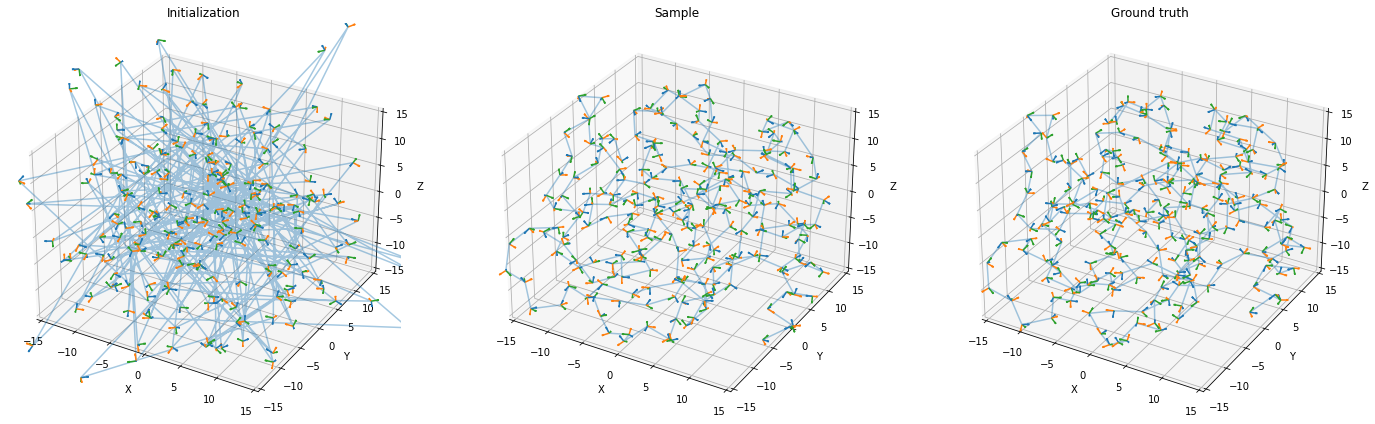

In [9]:
# Plot out SE(3)
final_rigid = sample_steps[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [10]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device), length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device), length_scale=scale_factor, return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz')
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.0153
Ca-RMSD: 0.2094
Alignment rotation: [-0.05830731 -0.28213616  0.03116493]
Alignment translation: [-1.0858349e-04  5.2680549e-05 -6.1544248e-05]
Alignment reflection: False


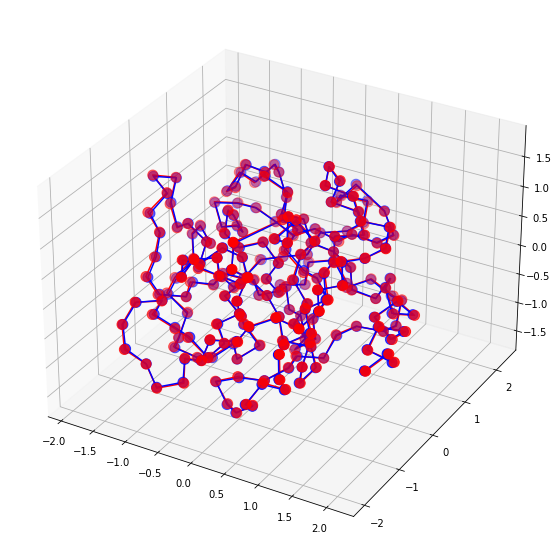

In [11]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

In [12]:
sample_traj = torch.stack(sample_steps)[:, 0]

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


Saved gif to: dev_diffusion.gif


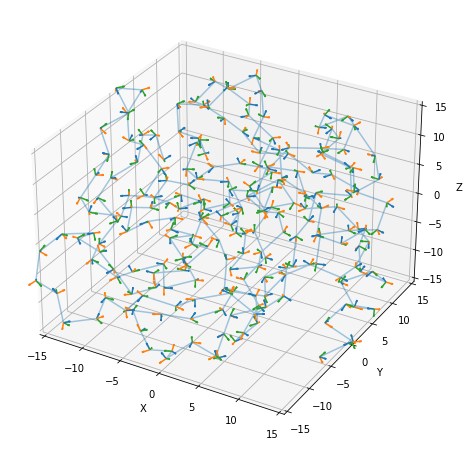

In [13]:
ax_lim = 15

fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
bb_mask = du.move_to_np(res_mask).astype(bool)

def extract_se3_vec(step, scale_factor=10.0):
    frame = sample_traj[step]
    frame = frame[bb_mask]
    se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
    return se3_vec


_ = plotting.plot_se3(extract_se3_vec(0), ax=ax, ax_lim=ax_lim)

def update(frame):
    ax.clear()
    plotting.plot_se3(extract_se3_vec(frame), ax=ax, ax_lim=ax_lim)

anim = FuncAnimation(
    fig,
    update,
    frames=list(range(1, exp.diffuser.num_t)),
    interval=10,
    blit=False)
writergif = animation.PillowWriter(fps=30) 
# f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
f = f'dev_diffusion.gif'
anim.save(f, writer=writergif)
print(f'Saved gif to: {f}')

KeyError: 'bb_mask'

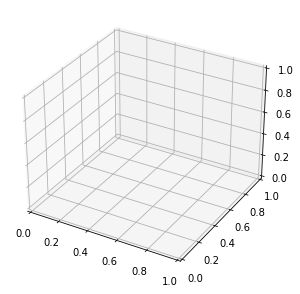

In [54]:
create_animation(0, sample_steps, torch.ones_like(res_mask), data_feats)

In [52]:
# TODO: Incorporate animations
def create_animation(b_idx, all_sampled_frames, sample_mask, data_raw):
    ax_lim = 10

    fig, ax = plt.subplots(1, 1, figsize=[5, 5], subplot_kw=dict(projection="3d"))
    bb_mask = du.move_to_np(data_raw['res_mask']).astype(bool)

    def extract_se3_vec(step, b_idx, scale_factor=10.0):
        frame = all_sampled_frames[step] * sample_mask[..., None] + data_raw['rigids_0'] * (1 - sample_mask[..., None])
        frame = frame[b_idx][bb_mask[b_idx]]
        se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
        return se3_vec


    _ = plotting.plot_se3(extract_se3_vec(0, b_idx), ax=ax, ax_lim=ax_lim)

    def update(frame):
        ax.clear()
        plotting.plot_se3(extract_se3_vec(frame, b_idx), ax=ax, ax_lim=ax_lim)

    anim = FuncAnimation(
        fig,
        update,
        frames=list(range(1, exp.diffuser.num_steps)),
        interval=10,
        blit=False)
    writergif = animation.PillowWriter(fps=30) 
    # f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
    f = f'dev_diffusion_{b_idx}.gif'
    anim.save(f, writer=writergif)
    print(f'Saved gif to: {f}')